# Principal components regression

### PCR: details

The idea is that often a small number of principal components is sufficient to explain most of the variability in the data, as well as the relationship with the data response. However, the PCA approach is unsupervised, so the response Y is not used. There is no guarantee that the directions that best explain the predictors will also be the best directions to use for predicting response. It is not a future selection method because each of the _M_ principal components used in the regression is a linear combinations of all _p_ of the original features.

Steps:

* find principal components (PCs)
* use k-fold cross-validation to choose a number of the PCs _M_ for a linear regression model
* evaluate the model performance on the test data


###  PCR: example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, explained_variance_score


Data `yarn` is a part of [`pls`]( https://CRAN.R-project.org/package=pls) R package.

__NIR spectra and density measurements of PET yarns__

A training set consisting of 28 near-infrared (NIR) spectra of PET yarns, measured at 268 wavelengths, and 28 corresponding densities.

|Variable|Description|
|--|--|
|X1...X268| NIR measurements|
|density| Numeric vector of densities|

In [2]:
yarn = pd.read_csv('../data/yarn.csv')

In [3]:
yarn.rename(columns={'yarn.density':'density'}, inplace=True)

In [4]:
# data contains 28 observations and 269 variables
# the PCA used to reduce a number of variables 
yarn.shape

(28, 269)

In [5]:
yarn.columns

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10',
       ...
       'X260', 'X261', 'X262', 'X263', 'X264', 'X265', 'X266', 'X267', 'X268',
       'density'],
      dtype='object', length=269)

In [6]:
NIR=yarn[[x for x in yarn.columns[:-1] ]]

In [7]:
# split into train and test data set
X_train, X_test, y_train, y_test = train_test_split(
                                    NIR, yarn.density, test_size=0.25, random_state=1)

In [8]:
# Step1. Standartize the data

# fit scaler on the train data, preprocess the test data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# find principal components
pca = PCA()

pcs_train = pca.fit_transform(X_train)
pcs_test = pca.transform(X_test)

In [10]:
pd.DataFrame({'Proportion of variance': pca.explained_variance_ratio_,
              'Cumulative proportion': np.cumsum(pca.explained_variance_ratio_)},
              index=[ 'PC'+str(x+1) for x in range(pca.n_components_)])

,Proportion of variance,Cumulative proportion
PC1,5.003432e-01,0.500343
PC2,3.150696e-01,0.815413
PC3,1.694492e-01,0.984862
PC4,8.729621e-03,0.993592
PC5,2.975617e-03,0.996567
PC6,1.200898e-03,0.997768
PC7,1.046394e-03,0.998815
PC8,3.788105e-04,0.999193
PC9,2.925822e-04,0.999486
PC10,1.468995e-04,0.999633


> The first 4 PSc explain 99% of variance in the data.

In [11]:
# 5-fold cross-validation with shuffle
kf_ = KFold( n_splits=5, shuffle=True, random_state=144)

In [12]:
# build linear regression
lm = LinearRegression()

Regression metrics:

$$\text{explained_variance} = 1-\frac{Var(y-\hat{y})}{Var(y)}$$

$$\text{MSE}(y, \hat{y})=\frac{1}{n}\displaystyle\sum_{i=1}^{n}(y-\hat{y})^2 $$

In [13]:
# perform cross-validation on the training data
# we compare models based on two differenet metrics 'mse' and 'explained_variance'

#(M-1) is a max number of principal components in a model
# the number of predictors < the number of observations to fit a regression model

M = 6  

mse=[]
expl_var=[]

for i in range(1,M):
    score_mse = - cross_val_score(lm, pcs_train[:, :i], y_train, 
                                  cv=kf_, scoring='neg_mean_squared_error').mean()
    
    score_expl_var = cross_val_score(lm, pcs_train[:, :i], y_train, 
                                     cv=kf_, scoring='explained_variance').mean()
    mse.append(score_mse)
    expl_var.append(score_expl_var)

pd.DataFrame({'MSE':mse, 'Explained Variance':expl_var}, 
             index=[str(i)+' PSc in model' for i in range(1,M)])    

,MSE,Explained Variance
1 PSc in model,87.157604,0.863554
2 PSc in model,102.115541,0.840011
3 PSc in model,7.481970,0.992426
4 PSc in model,1.402078,0.996726
5 PSc in model,1.609867,0.996836


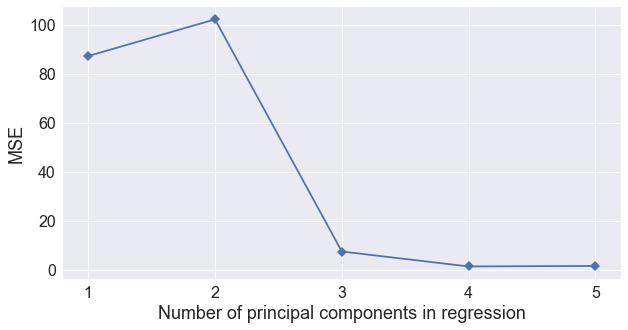

In [14]:
plt.figure(figsize=(10,5))
plt.style.use('seaborn')

plt.plot([int(i) for i in range(1,M)], mse, '-D')
plt.xlabel('Number of principal components in regression', fontsize=18)
plt.xticks([int(i) for i in range(1,M)],fontsize=16)
plt.ylabel('MSE', fontsize=18)
plt.yticks(fontsize=16)
plt.show()
plt.close()

In [15]:
# fit a regression model with the 3 PCs on training data
M = 3

lm.fit(pcs_train[:, : M], y_train)
y_pred = lm.predict(pcs_test[:, : M])

In [16]:
# evaluate training performance
# explained variance in the response

explained_variance_score(y_train, lm.predict(pcs_train[:, : M]))

0.9952051321822522

In [17]:
# evaluate test performance
# explained variance in the response 
explained_variance_score(y_test, y_pred)

0.9795238096186122

In [18]:
# mse, traininga data
mean_squared_error(y_train, lm.predict(pcs_train[:, : M]))

3.380022283407623

In [19]:
# mse, test data
mean_squared_error(y_test, y_pred)

17.381885522928297